In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL
from utilsforecast.plotting import plot_series
from tsfeatures import * 

from statsforecast import StatsForecast
from coreforecast.scalers import boxcox, boxcox_lambda
from statsmodels.tsa.seasonal import seasonal_decompose

from plotnine import *

# change working directory 
# Check if current directory has any .ipynb files
if any(fname.endswith(".ipynb") for fname in os.listdir()):
    os.chdir("..")

# load local package modules
from gas_pump_prices.preprocess import * 

%load_ext autoreload
%autoreload 2

# Setup 

In [41]:
df_gas = pd.read_csv('data/raw/fueltypesall.csv')

# convert date to datetime object 
df_gas['Date'] = pd.to_datetime(df_gas['Date'])
df_gas.drop('Type de carburant', axis=1, inplace=True)

# convert to long format 
df_gas = pd.melt(frame=df_gas, id_vars=['Date', 'Fuel Type'], 
        var_name='city',value_name='price')
df_gas = df_gas.query("`Fuel Type` == 'Regular Unleaded Gasoline'")

# read in inflation data
df_inflation = pd.read_csv('data/raw/1810000401_databaseLoadingData.csv')
df_inflation.columns = df_inflation.columns.str.lower()
df_gas_inf = df_inflation.query("`products and product groups` == 'Gasoline'").copy()
                                   
# compute dollars in terms of 2025 dollars
# 1) Compute CPIs centered on 2025
value_25 = df_gas_inf.query('ref_date == "2025-06"')['value']
df_gas_inf['cpi_2025'] = value_25.values/df_gas_inf['value']

# merge in CPI value based on year-month and compute 
df_gas['year_month'] = df_gas["Date"].dt.strftime("%Y-%m")
df_gas_inf["ref_date"] = pd.to_datetime(df_gas_inf["ref_date"])
df_gas_inf['date_ymw'] = df_gas_inf["ref_date"].dt.strftime("%Y-%m")

cols = ['date_ymw', 'value', 'cpi_2025']
df_gas = pd.merge(left=df_gas, right=df_gas_inf[cols],
                  left_on='year_month', right_on='date_ymw', how='left')


# NOTE: replace 1990-01 with 1990-02 and 2025-07 with 2025-06
df_gas.loc[df_gas['year_month'].eq("1990-01"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("1990-02"), 'cpi_2025'].iloc[0]
df_gas.loc[df_gas['year_month'].eq("2025-07"), 'cpi_2025'] = df_gas.loc[df_gas['year_month'].eq("2025-06"), 'cpi_2025'].iloc[0]

assert (df_gas['cpi_2025'].isna().sum() == 0), '''Check missing cpi_2025 values'''

# compute price adjusted metrics 
df_gas['price_2025'] = df_gas['price'] * df_gas['cpi_2025']

assert (df_gas['price_2025'].isna().sum() == 0), '''Check missing price_2025 values'''

# create toronto data
df_gas.to_csv('data/processed/data_ontario_gas.csv', index=False)

# 4. Time series features 
## 4.1. Some simple statistics 

In [6]:
df_aus_tour = pd.read_csv("data/raw/aus_tourism.csv", parse_dates=["ds"])
mean_df = df_aus_tour.groupby("unique_id", as_index=False)["y"].mean()
mean_df.sort_values(by="y").head(10)

summary_stats = tsfeatures(df_aus_tour, freq=4, features=[statistics],
    scale=False)
summary_stats[["unique_id", "min", "p25", "median", "p75", "max"]].head(10)

,unique_id,min,p25,median,p75,max
0,Adelaide Hills-South Australia-Business,0.000000,0.000000,1.255434,3.920368,28.601515
1,Adelaide Hills-South Australia-Holiday,0.000000,5.767673,8.515966,14.059997,35.751337
2,Adelaide Hills-South Australia-Other,0.000000,0.000000,0.907595,2.093167,8.953163
3,Adelaide Hills-South Australia-Visiting,0.777638,8.907923,12.206619,16.806339,81.102109
4,Adelaide-South Australia-Business,68.725393,133.893462,152.576618,176.935536,242.494368
5,Adelaide-South Australia-Holiday,108.033040,134.626822,153.945007,172.256676,223.557406
6,Adelaide-South Australia-Other,25.901846,43.865901,53.809463,62.523135,107.494657
7,Adelaide-South Australia-Visiting,136.611154,178.915998,205.581736,229.299111,269.535618
8,Alice Springs-Northern Territory-Business,1.008425,9.133369,13.324161,18.456365,34.077065
9,Alice Springs-Northern Territory-Holiday,2.808555,16.850803,31.523782,44.784402,76.541382


# 

## 4.2. ACF features

Several methods for computing autocorrelations: 

1. Compute sum of first ten squared autocorrelations. 
2. Create data of lagged differences (or even differences of differences). 
3. Compute differences between months from different years. 

Code below uses `tsfeatures()` to compute several autocorrelation metrics: 

1. First autocorrelaiton coefficient (`xacf1`)
2. Sum of squares from first 10 autocorrelations (`x_acf10`) 
3. First autocorrelation from differenced data (`diff1_acf1`)
4. Sum of squares from first 10 autocorrelations of differenced data (`diff1_acf10`)
5. Items 1-2 from twice differenced data (`diff2_acf1`, `diff2_acf10`)
4. Seasonal data (`diff2_acf10`)

In [9]:
acf_feat = tsfeatures(df_aus_tour, freq=4, features=[acf_features])
acf_feat.head(10).round(3)

,unique_id,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Adelaide Hills-South Australia-Business,0.071,0.134,-0.580,0.415,-0.750,0.746,-0.063
1,Adelaide Hills-South Australia-Holiday,0.131,0.313,-0.536,0.500,-0.716,0.906,0.208
2,Adelaide Hills-South Australia-Other,0.261,0.330,-0.253,0.317,-0.457,0.392,0.075
3,Adelaide Hills-South Australia-Visiting,0.139,0.117,-0.472,0.239,-0.626,0.408,0.170
4,Adelaide-South Australia-Business,0.033,0.131,-0.520,0.463,-0.676,0.741,0.201
5,Adelaide-South Australia-Holiday,0.046,0.372,-0.343,0.614,-0.487,0.558,0.351
6,Adelaide-South Australia-Other,0.517,1.154,-0.409,0.383,-0.675,0.792,0.342
7,Adelaide-South Australia-Visiting,0.068,0.294,-0.394,0.452,-0.518,0.447,0.345
8,Alice Springs-Northern Territory-Business,0.217,0.367,-0.500,0.381,-0.658,0.587,0.315
9,Alice Springs-Northern Territory-Holiday,-0.007,2.113,-0.153,2.113,-0.274,1.551,0.729


## 4.3. STL features

For time series data with strong trend-cycle component, variability of the remainder relative to the sum of $R_t + T_t$, $F_T$. should be small. 

$$
F_T = \max \Big(0, 1 - \frac{Var(R_t)}{Var(R_t + T_t)} \Big)
$$

Similarly, the strength of the seasonality component can be defined as 
$$
F_T = \max \Big(0, 1 - \frac{Var(R_t)}{Var(R_t + S_t)} \Big)
$$

Because $R_t$ can be greater than $S_t$/$/$T_t$, the maximum value is taken. 

These variability ratios are very useful when determining which time series have strong seasonality and/or trend-cycle components as they ratios can be easily visualized. It is also easy to identify the time series with the strongest seasonal component 

In the example with Australian tourism, we can easiy determine that 

1) Holiday visits have stronger seasonal trends. 
2) Western Australia has the strongest trend. 


Other info returned by `stl_features`: 

1. `peak` indicates the time period with the largest seasonal component. 
2. `trough` indicates time period with smallest seasonal component
3. `linearity` provides measure of trend component (obtained by fitting linear regression to trend component)
4. `curvature` provides measure of curvature in trend component (obtained by fitting quadratic regression to trend component)

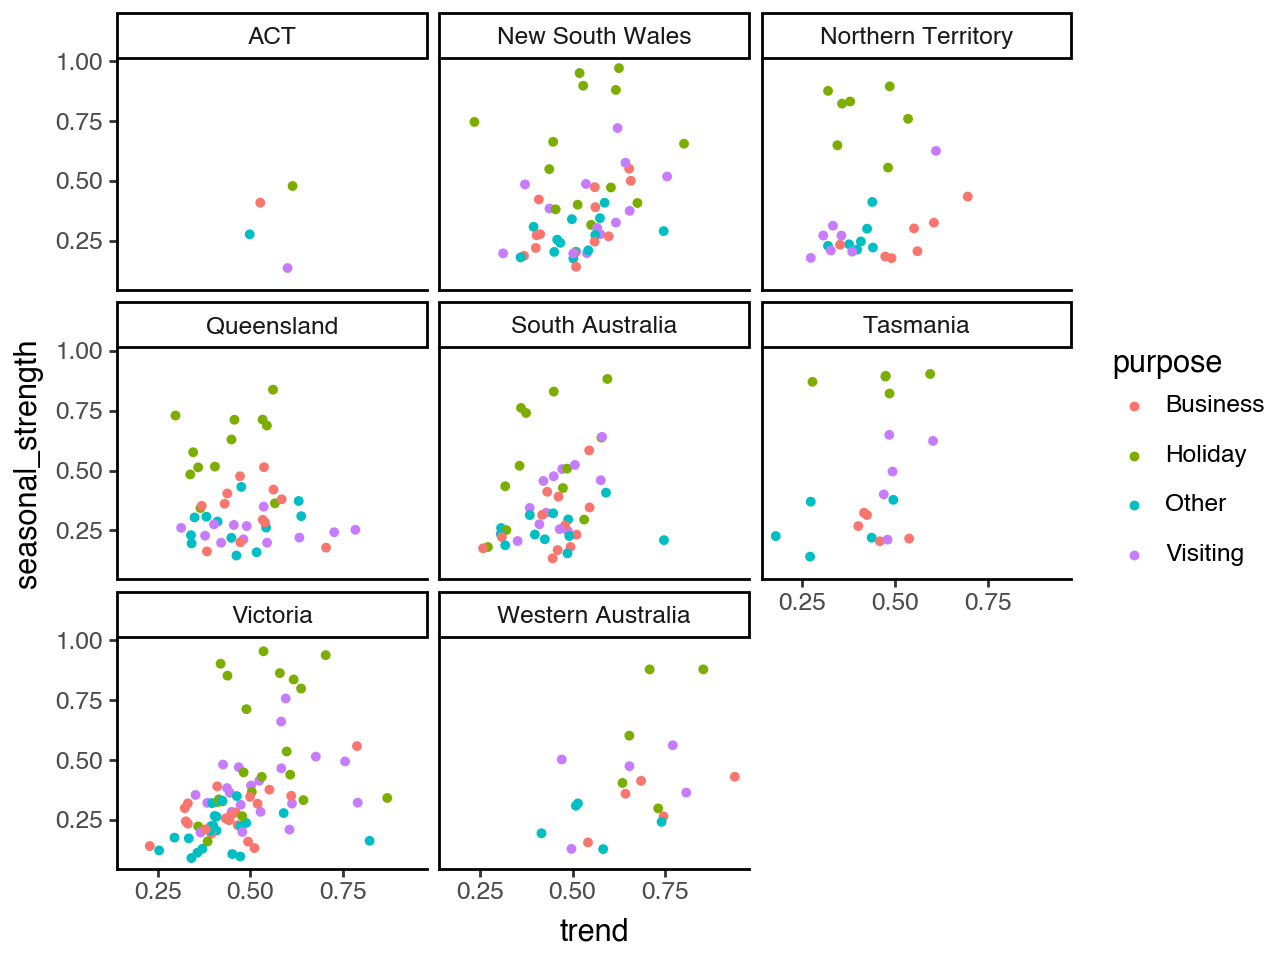

In [33]:
df_aus_tour = pd.read_csv("data/raw/aus_tourism.csv", parse_dates=["ds"])

stl_feat = tsfeatures(df_aus_tour, freq=4, features=[stl_features])
stl_feat[["region", "state", "purpose"]] = stl_feat["unique_id"].str.split("-", expand=True)

(ggplot(data=stl_feat, mapping=aes(x='trend', y='seasonal_strength', group='purpose', color='purpose')) + 
    geom_point(size=1) + 
    facet_wrap(facets='~state') + 
    theme_classic())

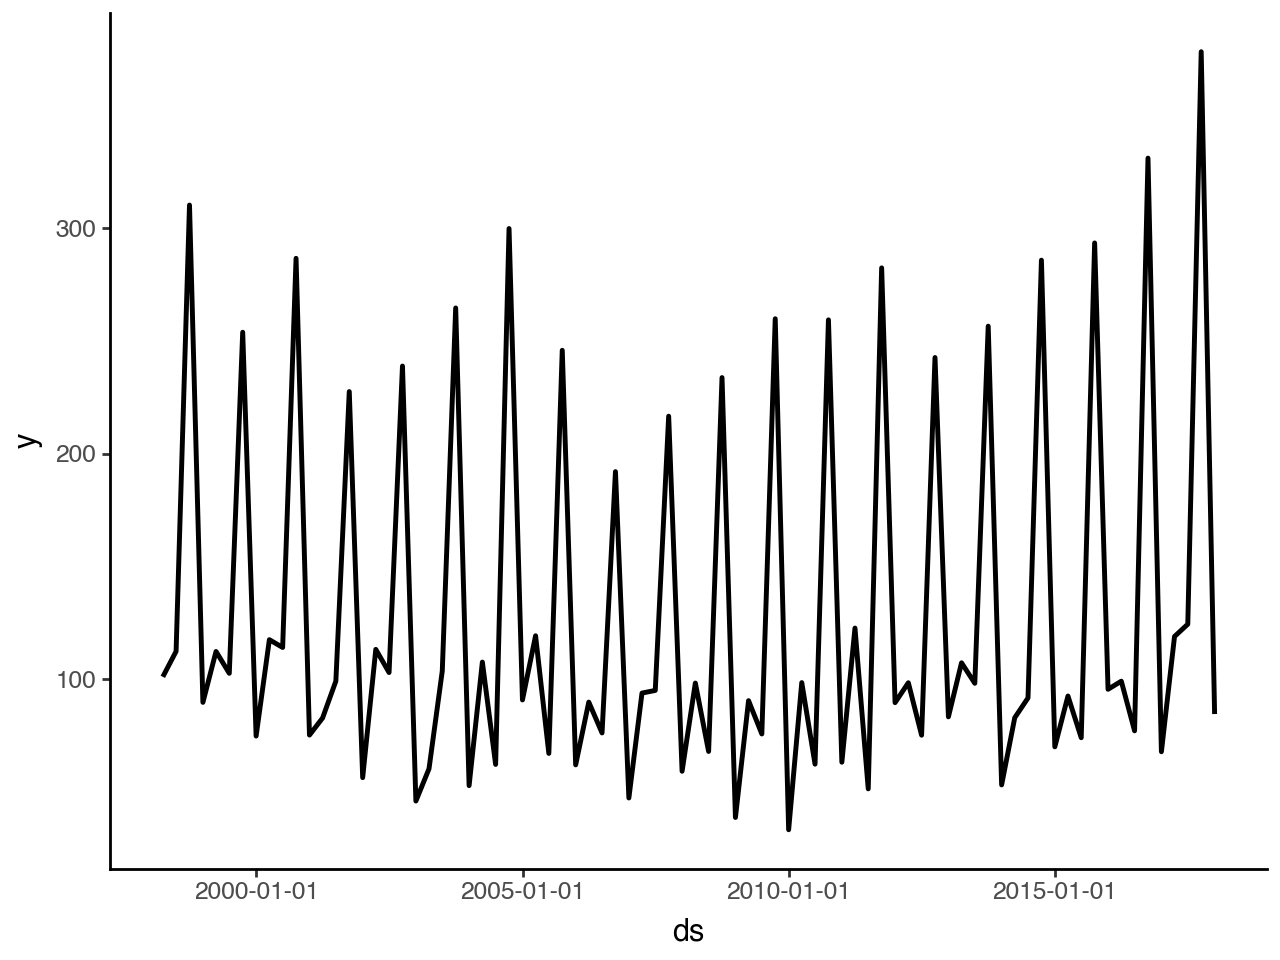

In [27]:
df_aus_tour = pd.read_csv("data/raw/aus_tourism.csv", parse_dates=["ds"])

max_seasonal_strength_row = stl_feat.loc[stl_feat["seasonal_strength"].idxmax()]

max_unique_id = max_seasonal_strength_row["unique_id"]

(ggplot(data=df_aus_tour.loc[df_aus_tour['unique_id'].eq(max_unique_id)], 
        mapping=aes(x='ds', y='y')) +
        geom_line(size=1) + 
        theme_classic())

Other features returned by `tsfeatures`: 

1. `hurst`: computes Hurst coefficient (measure of long memory). Series with long memory. 
2. `feat_spectral`: computes Shannon spectral entropy (measure of how easy it is to forecast). 
3. `box_pierce` gives Box-Pierce statistic for testing if a time series is white noise . 
4. `ljung-box` gives Ljung-Box statistic for testing if a time series is white 
5. `n_crossing_points`: computes number of times a time series crosses the median 
6. `stat_arch_lm` returnes Lagrange Multiplier (LM) test for autoregressive conditional heteroscedasticity 
7. `guerrero` computes optimal value for $\lambda$ for Box-Cox transformation. 

### 4.5. Exploring Canadian gas prices

In [42]:
df_ontario_gas = pd.read_csv('data/processed/data_ontario_gas.csv')

# 

In [40]:
df_ontario_gas['unique_id'].value_counts(dropna=False)

unique_id
Toronto East/Est    1855
Name: count, dtype: int64

In [43]:
df_ontario_gas.rename(columns={"city": "unique_id", 
                               'Date': 'ds', 
                               "price_2025": 'y'}, inplace=True)

In [44]:
all_features = [
    acf_features,
    arch_stat,
    crossing_points,
    entropy,
    flat_spots,
    heterogeneity,
    holt_parameters,
    lumpiness,
    nonlinearity,
    pacf_features,
    stl_features,
    stability,
    hw_parameters,
    unitroot_kpss,
    unitroot_pp,
    series_length,
    hurst,
]
all_feat = tsfeatures(df_ontario_gas, freq=4, features=all_features)
all_feat.head(10)


/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/miniconda3/lib/python3.13/site-packages/sklearn/linear_model/_base.py:282: RuntimeWarning: overflow encountered in matmul
  return X @ coef_.T + self.intercept_
/opt/miniconda3/lib/python3.13/site-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/opt/miniconda3/lib/python3.13/site-pack

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,entropy,crossing_points,arch_lm,x_acf1,x_acf10,diff1_acf1,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1
0,Kenora,NaN,1855,-1.702135,8.786946,0.978111,0.0,0.000000,0.990571,1,...,0.298032,1,0.990699,0.995849,9.575741,-0.021173,0.003072,-0.502278,0.254929,0.983938
1,London,0.847559,1855,-1434.188286,1.188265,0.132954,0.0,0.000000,0.474840,1,...,0.897241,689,0.147697,0.368728,0.368231,-0.351449,0.156168,-0.589186,0.374394,0.195613
2,North Bay,0.647285,1855,-522.920965,1.517317,0.799094,0.0,0.000000,0.625187,1,...,0.857537,501,0.739592,0.711549,0.988810,-0.156591,0.072549,-0.532345,0.326338,0.229266
3,Northern Average/Moyenne du nord de l'Ontario,NaN,1855,-901.452872,1.479822,0.310596,0.0,0.000000,0.613918,1,...,0.807905,481,0.354765,0.596198,1.390935,-0.278038,0.132437,-0.551063,0.343515,0.401136
4,Ontario Average/Moyenne provinciale,1.092351,1855,-1469.050844,2.481774,0.049997,0.0,0.024811,0.466270,1,...,0.864722,747,0.156968,0.362526,0.478417,-0.342602,0.165844,-0.586759,0.389866,0.222321
5,Ottawa,NaN,1855,-710.467592,2.953268,0.181139,0.0,0.016206,0.732481,1,...,0.666236,528,0.453156,0.677332,3.266223,-0.347487,0.145593,-0.586279,0.356343,0.577060
6,Parry Sound,NaN,1855,-1.126353,8.770719,0.928943,0.0,0.000000,0.991437,1,...,0.294024,1,0.991940,0.996186,9.628889,-0.067049,0.031519,-0.519376,0.333859,0.985892
7,Peterborough,NaN,1855,-1.366359,8.785909,0.873885,0.0,0.000000,0.990918,1,...,0.297881,1,0.986654,0.995472,9.596932,-0.110753,0.022910,-0.526029,0.290510,0.984688
8,Sault Saint Marie,0.738497,1855,-709.030208,2.656265,0.466677,0.0,0.000000,0.668525,1,...,0.798642,353,0.302047,0.660254,1.587519,-0.247159,0.115955,-0.551406,0.345327,0.417976
9,Southern Average/Moyenne du sud de l'Ontario,1.113020,1855,-1468.822522,2.845113,0.055851,0.0,0.023948,0.484588,1,...,0.858824,737,0.163719,0.375992,0.550399,-0.354083,0.169050,-0.595459,0.402167,0.240828
